In [72]:
print("These two below should match")
import sys
print(sys.executable)

!which python3
print("These two above should match")

These two below should match
/ocean/projects/cis260031p/shared/temu_conda/bin/python3
/ocean/projects/cis260031p/shared/temu_conda/bin/python3
These two above should match


In [73]:
# =============================================================================
# SECTION 0 — CONFIG  (change these to switch experiments)
# =============================================================================

ROOT_DIR     = "/ocean/projects/cis260031p/shared/dataset/Gelsight"
SUBSAMPLE    = 0.5        # fraction of dataset to load  (0.05 ≈ 25 samples — fast)
BATCH_SIZE   = 64
L_MAX        = 10          # max seconds per episode
SPLIT        = 'object'    # 'object' | 'pose' | 'random'
TEST_OBJECTS = ['mug', 'bowl']
TEST_POSES   = [1, 2, 3, 4, 5]
SIGMA        = 1.0         # DRS target S≠/S= ratio
SAMPLE_IDX   = 0           # which sample to use for per-sample inspection cells

In [74]:
# =============================================================================
# SECTION 1 — IMPORTS & CONSTANTS
# =============================================================================

import sys, os, random
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
from torch.utils.data import DataLoader, Subset

print("======== DONE WITH IMPORTS ===========")

# Add project dir to path so imports work regardless of cwd
sys.path.insert(0, str(Path("__file__").resolve().parent)
                if "__file__" in dir() else os.getcwd())

import dataloader as _dl
from dataloader import (
    PoseItDataset, split_by_object, split_by_pose,
    uniform_random_split, collate_variable_length,
    F1, F2, FT_DIM, GR_DIM,
    _parse_folder_name, _read_stages, _read_labels,
    _read_csv_timeseries, _list_image_files,
    _sample_bucket, _sample_image_bucket,
    _load_image, _build_sample, IMG_TRANSFORM, LABEL_MAP,
)
from model import GraspStabilityLSTM
from sampler import DRSSampler

# Apply the episode length cap BEFORE constructing any dataset
_dl.L = L_MAX

print(f"F1={F1}  (image frames/sec)")
print(f"F2={F2}  (sensor readings/sec)")
print(f"FT_DIM={FT_DIM}  (F2*6 = {F2}*6)")
print(f"GR_DIM={GR_DIM}  (F2*2 = {F2}*2)")
print(f"L_MAX={_dl.L}  (max seconds per episode)")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

======== DONE WITH IMPORTS ===========
F1=1  (image frames/sec)
F2=1  (sensor readings/sec)
FT_DIM=6  (F2*6 = 1*6)
GR_DIM=2  (F2*2 = 1*2)
L_MAX=10  (max seconds per episode)
Device: cuda


In [75]:
# =============================================================================
# SECTION 2 — SINGLE SAMPLE: RAW FILE INSPECTION
# =============================================================================

all_dirs = sorted(d for d in Path(ROOT_DIR).iterdir() if d.is_dir())
sample_dir = all_dirs[SAMPLE_IDX]
print(f"Inspecting: {sample_dir.name}\n")

# --- Parsed metadata from folder name ---
meta = _parse_folder_name(sample_dir.name)
print("Folder name metadata:")
for k, v in meta.items():
    print(f"  {k:12s}: {v}")

# --- stages.csv ---
stages = _read_stages(sample_dir / 'stages.csv')
print(f"\nstages.csv ({len(stages)} entries):")
for k, v in sorted(stages.items(), key=lambda x: x[1]):
    print(f"  {k:15s}: {v}")

# --- label.csv ---
labels = _read_labels(sample_dir / 'label.csv')
print(f"\nlabel.csv:")
for k, v in labels.items():
    num = LABEL_MAP.get(v, -1)
    print(f"  {k:12s}: {v!r}  → {num}")

# --- Temporal window ---
t_grasp     = stages.get('grasping', stages.get('grasp'))
t_pose      = stages.get('pose')
t_stability = stages.get('stability')
t_retract   = stages.get('retract')
seconds     = list(range(t_grasp, t_stability))
raw_len     = len(seconds)
if _dl.L is not None:
    if raw_len < _dl.L:
        print(f"\n[WARN] Episode too short ({raw_len}s < L={_dl.L}) — would be DROPPED by dataset loader.")
    else:
        seconds = seconds[-_dl.L:]   # last L seconds (closest to stability)
print(f"\nTemporal window  (phase='grasp+pose'):")
print(f"  t_grasp={t_grasp}, t_pose={t_pose}, t_stability={t_stability}, t_retract={t_retract}")
print(f"  full range: {raw_len}s  →  training window: {len(seconds)}s  "
      f"(L={_dl.L}, {'last L secs used' if raw_len >= (_dl.L or 0) else 'TOO SHORT — dropped'})")

# --- File counts ---
ft_ts, ft_val     = _read_csv_timeseries(sample_dir / 'f_t.csv',     time_col=0)
gr_ts, gr_val     = _read_csv_timeseries(sample_dir / 'gripper.csv', time_col=0)
gel_triples       = _list_image_files(sample_dir / 'gelsight')
rgb_triples       = _list_image_files(sample_dir / 'rgb')

window_mask_ft  = (ft_ts >= t_grasp) & (ft_ts < t_stability)
window_mask_gr  = (gr_ts >= t_grasp) & (gr_ts < t_stability)
gel_in_window   = [(ts, fi, p) for ts, fi, p in gel_triples if t_grasp <= ts < t_stability]
rgb_in_window   = [(ts, fi, p) for ts, fi, p in rgb_triples if t_grasp <= ts < t_stability]

print(f"\nFile inventory (full episode):")
print(f"  GelSight frames  : {len(gel_triples):5d}  ({len(gel_in_window)} in grasp+pose window)")
print(f"  RGB frames       : {len(rgb_triples):5d}  ({len(rgb_in_window)} in grasp+pose window)")
print(f"  F/T rows         : {len(ft_ts):5d}  ({window_mask_ft.sum()} in grasp+pose window)")
print(f"  Gripper rows     : {len(gr_ts):5d}  ({window_mask_gr.sum()} in grasp+pose window)")

# Per-second frame counts in the window
print(f"\nPer-second frame counts:")
print(f"  {'Second':>10}  {'GelSight':>9}  {'RGB':>5}  {'FT rows':>8}  {'Grip rows':>10}")
for sec in seconds[:6]:
    n_gel = sum(1 for ts, _, _ in gel_in_window if ts == sec)
    n_rgb = sum(1 for ts, _, _ in rgb_in_window if ts == sec)
    n_ft  = int((ft_ts == sec).sum())
    n_gr  = int((gr_ts == sec).sum())
    print(f"  {sec:>10}  {n_gel:>9}  {n_rgb:>5}  {n_ft:>8}  {n_gr:>10}")
if len(seconds) > 6:
    print(f"  ... ({len(seconds)-6} more seconds)")


Inspecting: airQualityMonitor_1613780549_F80_pose10

Folder name metadata:
  object      : airQualityMonitor
  start_ts    : 1613780549
  force       : 80.0
  pose_idx    : 10

stages.csv (6 entries):
  grasping       : 1613780549
  pose           : 1613780554
  stability      : 1613780559
  retract        : 1613780568
  release        : 1613780578
  fin            : 1613780581

label.csv:
  grasp       : 'slip'  → 1
  pose        : 'pass'  → 0
  stability   : 'pass'  → 0

Temporal window  (phase='grasp+pose'):
  t_grasp=1613780549, t_pose=1613780554, t_stability=1613780559, t_retract=1613780568
  full range: 10s  →  training window: 10s  (L=10, last L secs used)

File inventory (full episode):
  GelSight frames  :   947  (276 in grasp+pose window)
  RGB frames       :   159  (46 in grasp+pose window)
  F/T rows         :  3170  (920 in grasp+pose window)
  Gripper rows     :   292  (81 in grasp+pose window)

Per-second frame counts:
      Second   GelSight    RGB   FT rows   Grip rows

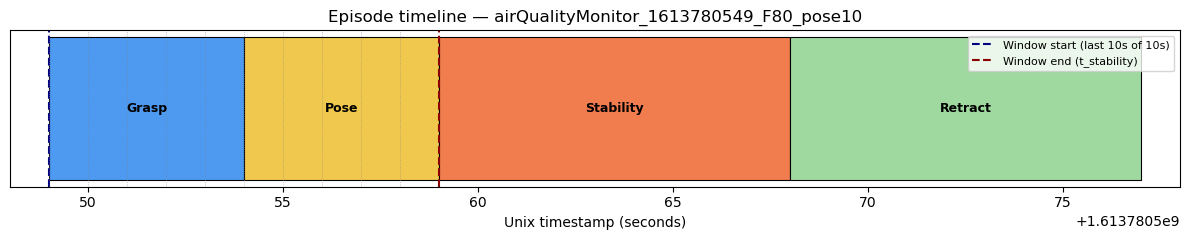


Training window: 10 seconds → T=10 LSTM timesteps
  Each timestep contains: F1=1 image frames + F2=1 FT readings + F2=1 gripper readings


In [76]:
# =============================================================================
# SECTION 3 — TEMPORAL STRUCTURE PLOT
# =============================================================================

phase_order  = ['grasping', 'pose', 'stability', 'retract']
phase_colors = ['#4e9af1', '#f1c84e', '#f17c4e', '#a0d9a0']
phase_labels = ['Grasp', 'Pose', 'Stability', 'Retract']

# Build (start, end) for each phase from stages
phase_bounds = {}
for i, ph in enumerate(phase_order[:-1]):
    t_start = stages.get(ph, stages.get('grasping') if ph == 'grasping' else None)
    t_end   = stages.get(phase_order[i + 1])
    if t_start is not None and t_end is not None:
        phase_bounds[ph] = (t_start, t_end)
last_ph = phase_order[-1]
if last_ph in stages:
    last_end = stages[last_ph] + max(
        (stages[last_ph] - stages.get(phase_order[-2], stages[last_ph])), 2)
    phase_bounds[last_ph] = (stages[last_ph], last_end)

t_min = min(v[0] for v in phase_bounds.values())
t_max = max(v[1] for v in phase_bounds.values())

fig, ax = plt.subplots(figsize=(12, 2.5))
for i, (ph, col, lbl) in enumerate(zip(phase_order, phase_colors, phase_labels)):
    if ph not in phase_bounds:
        continue
    t0, t1 = phase_bounds[ph]
    ax.barh(0, t1 - t0, left=t0, height=0.5, color=col, edgecolor='k', linewidth=0.8)
    ax.text((t0 + t1) / 2, 0, lbl, ha='center', va='center', fontsize=9, fontweight='bold')

# Mark the training window — last L seconds of grasp+pose, ending at t_stability
t_win_start = seconds[0] if seconds else t_grasp   # start of last-L window
t_win_end   = (seconds[-1] + 1) if seconds else t_stability
ax.axvline(t_win_start, color='navy', linestyle='--', linewidth=1.5,
           label=f'Window start (last {len(seconds)}s of {raw_len}s)')
ax.axvline(t_win_end,   color='darkred', linestyle='--', linewidth=1.5,
           label='Window end (t_stability)')

# Shade the dropped prefix (t_grasp to t_win_start) if any was trimmed
if t_win_start > t_grasp:
    ax.axvspan(t_grasp, t_win_start, alpha=0.15, color='gray', label='Dropped prefix')

# Mark each sampled second as a tick
for s in seconds:
    ax.axvline(s, color='gray', linestyle=':', linewidth=0.6, alpha=0.6)

ax.set_xlim(t_min - 1, t_max + 1)
ax.set_yticks([])
ax.set_xlabel("Unix timestamp (seconds)")
ax.set_title(f"Episode timeline — {sample_dir.name}")
ax.legend(fontsize=8, loc='upper right')
plt.tight_layout()
plt.show()

print(f"\nTraining window: {len(seconds)} seconds → T={len(seconds)} LSTM timesteps")
print(f"  Each timestep contains: F1={F1} image frames + F2={F2} FT readings + F2={F2} gripper readings")


Baseline frame: gelsight_0_1613780549.jpg
  Tensor shape:  torch.Size([3, 224, 224])  (C, H, W)
  Pixel range:   [-2.084, 2.605]  (after ImageNet normalize)



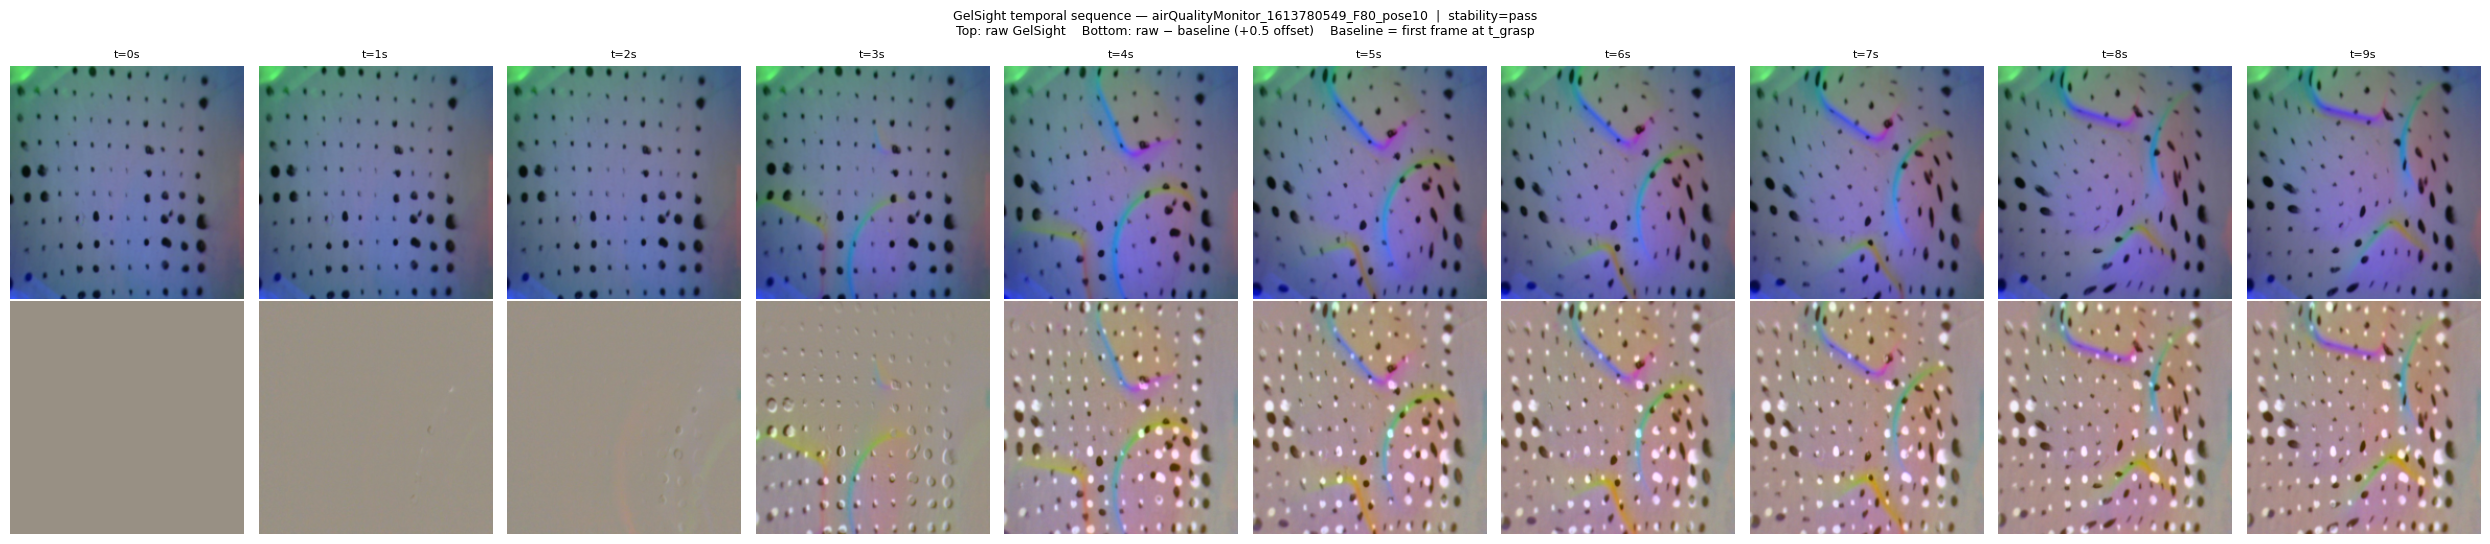


Diff pixel stats (raw − baseline) across all 10 seconds:
     t    max|diff|    mean|diff|   frames avail
  t= 0s   0.0000        0.0000           6
  t= 1s   0.5577        0.0229          31
  t= 2s   0.5926        0.0313          30
  t= 3s   2.1961        0.1210          30
  t= 4s   2.9978        0.2937          30
  t= 5s   3.3638        0.3033          30
  t= 6s   3.2941        0.3032          29
  t= 7s   3.2418        0.3074          30
  t= 8s   2.9978        0.3077          30
  t= 9s   2.9978        0.3125          30


In [77]:
# =============================================================================
# SECTION 4 — GELSIGHT PREPROCESSING (Baseline Subtraction)
# =============================================================================

# Build second→paths mapping
gel_by_sec = {}
for ts, _, p in gel_triples:
    gel_by_sec.setdefault(ts, []).append(p)

# --- Baseline: first GelSight frame at t_grasp ---
baseline_paths = gel_by_sec.get(t_grasp, [])
baseline_t     = _load_image(baseline_paths[0] if baseline_paths else None)
print(f"Baseline frame: {baseline_paths[0].name if baseline_paths else 'NONE (zeros)'}")
print(f"  Tensor shape:  {baseline_t.shape}  (C, H, W)")
print(f"  Pixel range:   [{baseline_t.min():.3f}, {baseline_t.max():.3f}]  (after ImageNet normalize)\n")

def _to_display(t):
    """Undo ImageNet normalize then clip to [0,1] for imshow."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (t * std + mean).clamp(0, 1).permute(1,2,0).numpy()

# --- Temporal filmstrip: 2*F1 rows × T cols ---
# Top F1 rows    = raw GelSight frame [0 … F1-1] at each second
# Bottom F1 rows = (raw − baseline + 0.5) difference at each second
n_secs = len(seconds)
n_rows = 2 * F1
fig_w  = max(6, 2.5 * n_secs)
fig_h  = max(4, 2.8 * n_rows)

fig, axes = plt.subplots(n_rows, n_secs, figsize=(fig_w, fig_h), squeeze=False)

for col, sec in enumerate(seconds):
    available = gel_by_sec.get(sec, [])
    sampled   = _sample_image_bucket(available, f=F1)
    t_offset  = sec - t_grasp

    for fi in range(F1):
        raw_ax  = axes[fi][col]        # top half — raw
        diff_ax = axes[F1 + fi][col]   # bottom half — difference

        if sampled is None:
            for ax in (raw_ax, diff_ax):
                ax.text(0.5, 0.5, 'EMPTY', ha='center', va='center',
                        transform=ax.transAxes, fontsize=8)
        else:
            raw_t  = _load_image(sampled[fi])
            diff_t = raw_t - baseline_t
            raw_ax.imshow(_to_display(raw_t))
            diff_ax.imshow(_to_display(diff_t + 0.5))

        raw_ax.set_title(f"t={t_offset}s", fontsize=8)
        if col == 0:
            raw_ax.set_ylabel(f"Raw\n(frame {fi})", fontsize=8, labelpad=2)
            diff_ax.set_ylabel(f"Diff\n(frame {fi})", fontsize=8, labelpad=2)
        raw_ax.axis('off')
        diff_ax.axis('off')

label_str = labels.get('stability', '?')
plt.suptitle(
    f"GelSight temporal sequence — {sample_dir.name}  |  stability={label_str}\n"
    f"Top: raw GelSight    Bottom: raw − baseline (+0.5 offset)"
    f"    Baseline = first frame at t_grasp",
    fontsize=9,
)
plt.tight_layout()
plt.show()

# --- Pixel stats across the full window ---
print(f"\nDiff pixel stats (raw − baseline) across all {n_secs} seconds:")
print(f"  {'t':>4}   {'max|diff|':>10}   {'mean|diff|':>11}   {'frames avail':>12}")
for sec in seconds:
    available = gel_by_sec.get(sec, [])
    sampled   = _sample_image_bucket(available, f=F1)
    if sampled:
        raw_t  = _load_image(sampled[0])
        diff_t = raw_t - baseline_t
        print(f"  t={sec - t_grasp:2d}s   {diff_t.abs().max():.4f}        {diff_t.abs().mean():.4f}"
              f"         {len(available):3d}")
    else:
        print(f"  t={sec - t_grasp:2d}s   EMPTY BUCKET")

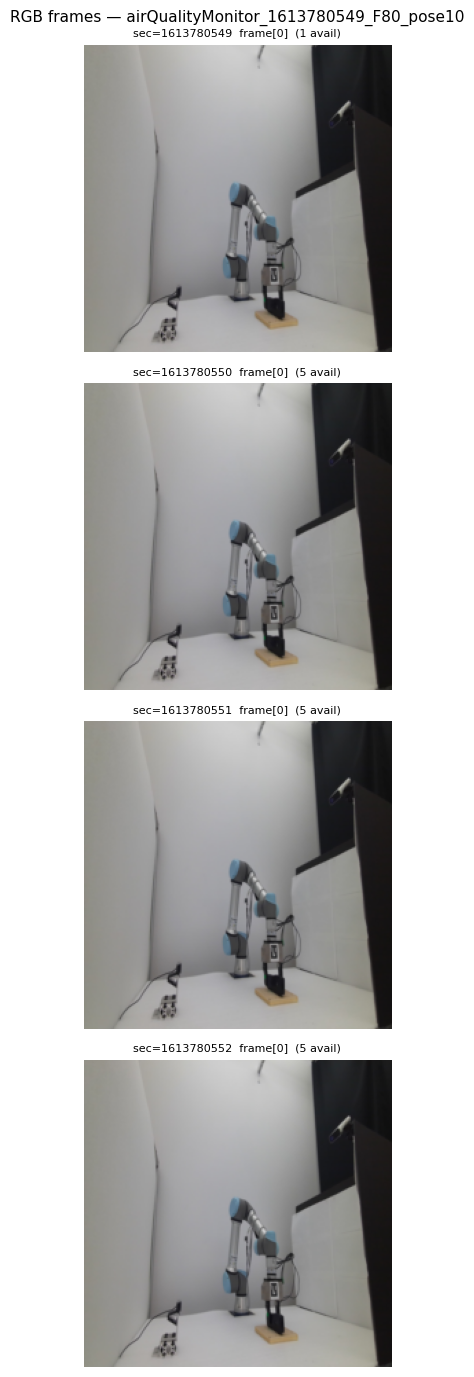

Shape trace: PIL → ToTensor → Normalize → final tensor
  PIL size:     (1280, 720)  (W×H)
  After Resize: (224, 224)
  After ToTensor: torch.Size([3, 224, 224])  range=[0.055,0.816]
  After Normalize: torch.Size([3, 224, 224])  range=[-1.861,1.821]


In [78]:
# =============================================================================
# SECTION 5 — RGB FRAMES
# =============================================================================

rgb_by_sec = {}
for ts, _, p in rgb_triples:
    rgb_by_sec.setdefault(ts, []).append(p)

# Show F1 sampled RGB frames for the first 4 seconds
n_show  = min(4, len(seconds))
fig, axes = plt.subplots(n_show, F1, figsize=(4 * F1, 3.5 * n_show))
if n_show == 1:
    axes = [axes]

for row, sec in enumerate(seconds[:n_show]):
    available = rgb_by_sec.get(sec, [])
    sampled   = _sample_image_bucket(available, f=F1)
    for col in range(F1):
        ax = axes[row][col] if F1 > 1 else axes[row]
        if sampled is None or sampled[col] is None:
            ax.text(0.5, 0.5, 'EMPTY', ha='center', va='center', transform=ax.transAxes)
        else:
            ax.imshow(_to_display(_load_image(sampled[col])))
        ax.set_title(f"sec={sec}  frame[{col}]  ({len(available)} avail)", fontsize=8)
        ax.axis('off')

plt.suptitle(f"RGB frames — {sample_dir.name}", fontsize=11)
plt.tight_layout()
plt.show()

# Shape trace for one frame
print("Shape trace: PIL → ToTensor → Normalize → final tensor")
p = rgb_by_sec.get(seconds[0], [None])[0]
if p:
    pil   = Image.open(p).convert('RGB')
    print(f"  PIL size:     {pil.size}  (W×H)")
    import torchvision.transforms.functional as TF
    resized = TF.resize(pil, [224, 224])
    print(f"  After Resize: {resized.size}")
    arr = TF.to_tensor(resized)
    print(f"  After ToTensor: {arr.shape}  range=[{arr.min():.3f},{arr.max():.3f}]")
    final = IMG_TRANSFORM(pil)
    print(f"  After Normalize: {final.shape}  range=[{final.min():.3f},{final.max():.3f}]")

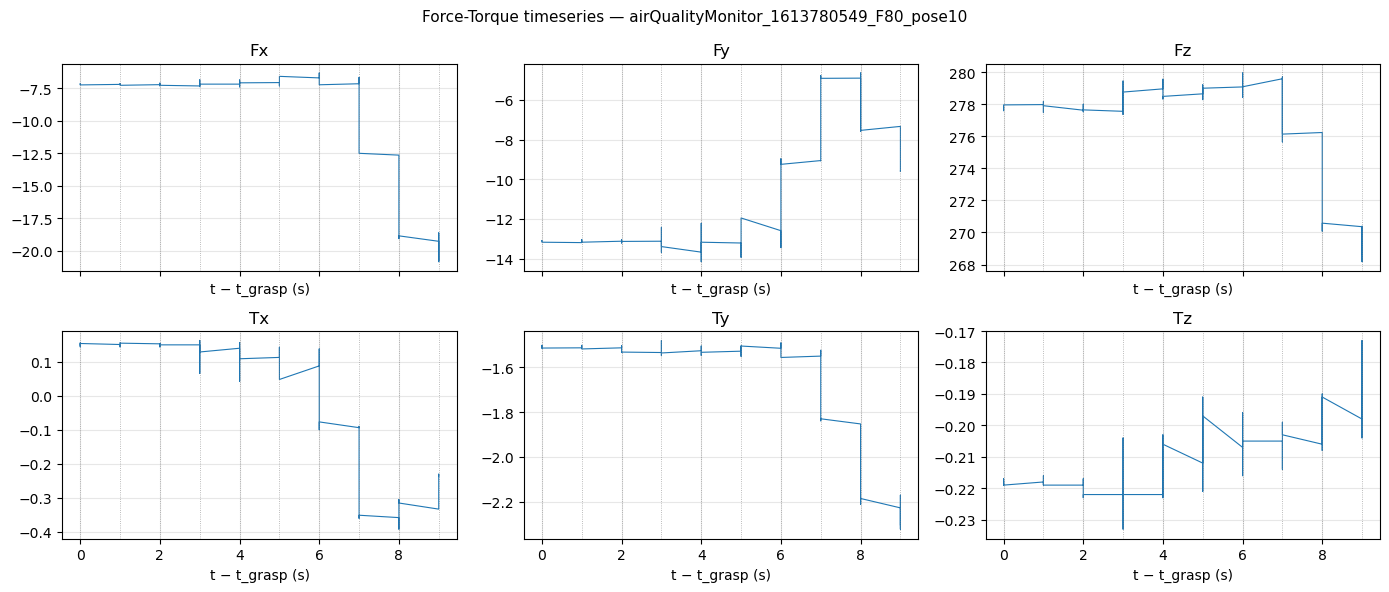


_sample_bucket demo — F/T for first two seconds:
  sec=1613780549: k=20 → linspace picks rows [0] → shape (6,)
    result[:6] = [-7.1800e+00 -1.3100e+01  2.7782e+02  1.4900e-01 -1.5090e+00 -2.1800e-01]
    result[6:] = []  (second reading)
  sec=1613780550: k=100 → linspace picks rows [0] → shape (6,)
    result[:6] = [-7.1900e+00 -1.3190e+01  2.7797e+02  1.5100e-01 -1.5130e+00 -2.1800e-01]
    result[6:] = []  (second reading)


In [79]:
# =============================================================================
# SECTION 6 — FORCE-TORQUE DEEP DIVE
# =============================================================================

ft_labels = ['Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz']

# Mask to the training window
win_ft_mask = (ft_ts >= t_grasp) & (ft_ts < (seconds[-1] + 1 if seconds else t_stability))
win_ft_ts   = ft_ts[win_ft_mask].astype(float)
win_ft_val  = ft_val[win_ft_mask]

fig, axes = plt.subplots(2, 3, figsize=(14, 6), sharex=True)
for i, (ax, lbl) in enumerate(zip(axes.flat, ft_labels)):
    ax.plot(win_ft_ts - win_ft_ts[0], win_ft_val[:, i], linewidth=0.8)
    for s in seconds:
        ax.axvline(s - t_grasp, color='gray', linestyle=':', linewidth=0.6, alpha=0.7)
    ax.set_title(lbl)
    ax.set_xlabel("t − t_grasp (s)")
    ax.grid(True, alpha=0.3)
plt.suptitle(f"Force-Torque timeseries — {sample_dir.name}", fontsize=11)
plt.tight_layout()
plt.show()

# --- Show _sample_bucket logic for one second ---
print("\n_sample_bucket demo — F/T for first two seconds:")
for sec in seconds[:2]:
    mask   = ft_ts == sec
    bucket = ft_val[mask]            # (k, 6)
    k      = len(bucket)
    result = _sample_bucket(bucket, n_cols=6, f=F2)
    if result is None:
        status = f"WARN: k={k} < F2={F2} → sample skipped"
    else:
        idx    = np.round(np.linspace(0, k-1, F2)).astype(int)
        status = f"k={k} → linspace picks rows {idx.tolist()} → shape ({F2*6},)"
    print(f"  sec={sec}: {status}")
    if result is not None:
        print(f"    result[:6] = {result[:6].round(4)}")
        print(f"    result[6:] = {result[6:].round(4)}  (second reading)")

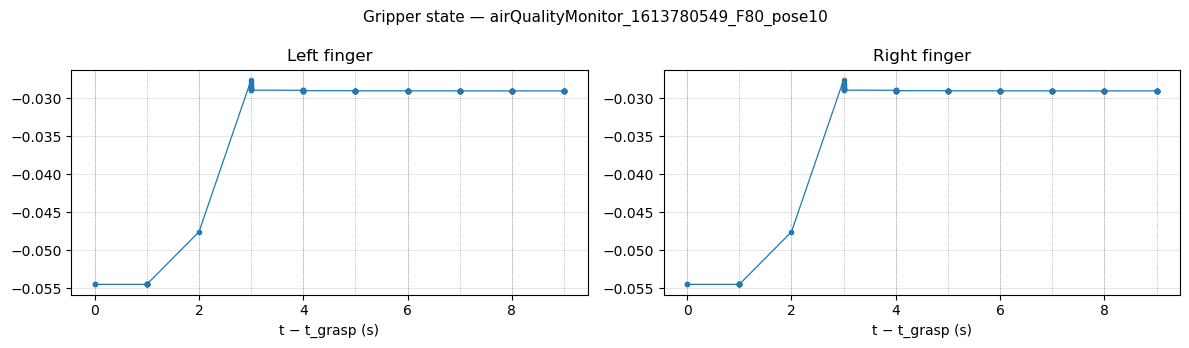


gripper_force (from folder name): 80.0 N  →  tensor([80.0])

_sample_bucket demo — gripper for first two seconds:
  sec=1613780549: k=2 → picks rows [0] → [-0.0545 -0.0545]
  sec=1613780550: k=9 → picks rows [0] → [-0.0545 -0.0545]


In [80]:
# =============================================================================
# SECTION 7 — GRIPPER STATE
# =============================================================================

win_gr_mask = (gr_ts >= t_grasp) & (gr_ts < (seconds[-1] + 1 if seconds else t_stability))
win_gr_ts   = gr_ts[win_gr_mask].astype(float)
win_gr_val  = gr_val[win_gr_mask]

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharex=True)
for i, (ax, lbl) in enumerate(zip(axes, ['Left finger', 'Right finger'])):
    ax.plot(win_gr_ts - win_gr_ts[0], win_gr_val[:, i], marker='o', markersize=3, linewidth=0.9)
    for s in seconds:
        ax.axvline(s - t_grasp, color='gray', linestyle=':', linewidth=0.6, alpha=0.7)
    ax.set_title(lbl)
    ax.set_xlabel("t − t_grasp (s)")
    ax.grid(True, alpha=0.3)
plt.suptitle(f"Gripper state — {sample_dir.name}", fontsize=11)
plt.tight_layout()
plt.show()

print(f"\ngripper_force (from folder name): {meta['force']} N  →  tensor([{meta['force']:.1f}])")

print("\n_sample_bucket demo — gripper for first two seconds:")
for sec in seconds[:2]:
    mask   = gr_ts == sec
    bucket = gr_val[mask]
    k      = len(bucket)
    result = _sample_bucket(bucket, n_cols=2, f=F2)
    if result is None:
        print(f"  sec={sec}: WARN k={k} < F2={F2}")
    else:
        idx = np.round(np.linspace(0, k-1, F2)).astype(int)
        print(f"  sec={sec}: k={k} → picks rows {idx.tolist()} → {result.round(4)}")

In [81]:
# =============================================================================
# SECTION 8 — FULL _build_sample TRACE (all shapes)
# =============================================================================

print(f"Building sample from: {sample_dir.name}")
print("=" * 60)

s = _build_sample(sample_dir)

if s is None:
    print("_build_sample returned None — this sample was skipped")
    print("(likely a bucket with 0 < k < F frames, or missing stages/labels)")
else:
    tensor_keys = ['tactile', 'rgb', 'ft', 'gripper', 'gripper_force', 'label', 'pose_label']
    for k in tensor_keys:
        v = s[k]
        if hasattr(v, 'shape'):
            print(f"  {k:20s}: {str(tuple(v.shape)):30s}  dtype={v.dtype}")
        else:
            print(f"  {k:20s}: {v}")

    print(f"\n  {'object':20s}: {s['object']}")
    print(f"  {'pose_idx':20s}: {s['pose_idx']}")
    print(f"  {'force':20s}: {s['force']} N")
    print(f"  {'grasp_label':20s}: {s['grasp_label']}  (stored in .samples but NOT in __getitem__)")

    T  = s['tactile'].shape[0]
    print(f"\nSummary: T={T} seconds")
    print(f"  tactile  : (T={T}, F1={F1}, 3, 224, 224)")
    print(f"  rgb      : (T={T}, F1={F1}, 3, 224, 224)")
    print(f"  ft       : (T={T}, FT_DIM={FT_DIM})")
    print(f"  gripper  : (T={T}, GR_DIM={GR_DIM})")
    print(f"\n  label (stability/retract) = {s['label'].item()}  {'[PASS]' if s['label']==0 else '[SLIP/DROP]'}")
    print(f"  pose_label               = {s['pose_label'].item()}  {'[PASS]' if s['pose_label']==0 else '[SLIP/DROP]'}")
    eq = "S=" if s['label'].item() == s['pose_label'].item() else "S≠"
    print(f"  DRS group                : {eq}  (label {'==' if eq=='S=' else '!='} pose_label)")

Building sample from: airQualityMonitor_1613780549_F80_pose10
  tactile             : (10, 1, 3, 224, 224)            dtype=torch.float32
  rgb                 : (10, 1, 3, 224, 224)            dtype=torch.float32
  ft                  : (10, 6)                         dtype=torch.float32
  gripper             : (10, 2)                         dtype=torch.float32
  gripper_force       : (1,)                            dtype=torch.float32
  label               : ()                              dtype=torch.int64
  pose_label          : ()                              dtype=torch.int64

  object              : airQualityMonitor
  pose_idx            : 10
  force               : 80.0 N
  grasp_label         : 1  (stored in .samples but NOT in __getitem__)

Summary: T=10 seconds
  tactile  : (T=10, F1=1, 3, 224, 224)
  rgb      : (T=10, F1=1, 3, 224, 224)
  ft       : (T=10, FT_DIM=6)
  gripper  : (T=10, GR_DIM=2)

  label (stability/retract) = 0  [PASS]
  pose_label               = 0  [PAS

[WARN] Skipping ductTape_1611177444_F80_pose5: [Errno 2] No such file or directory: '/ocean/projects/cis260031p/shared/dataset/Gelsight/ductTape_1611177444_F80_pose5/gelsight'
Loaded 178 samples (314 skipped)  [L=10, F1=1, F2=1, phase='grasp+pose']
Subsampled to 89 samples

Total samples loaded: 89

Stability label:  51 pass (57.3%)  |  38 slip/drop (42.7%)
Pose label:       70 pass (78.7%)  |  19 slip/drop (21.3%)


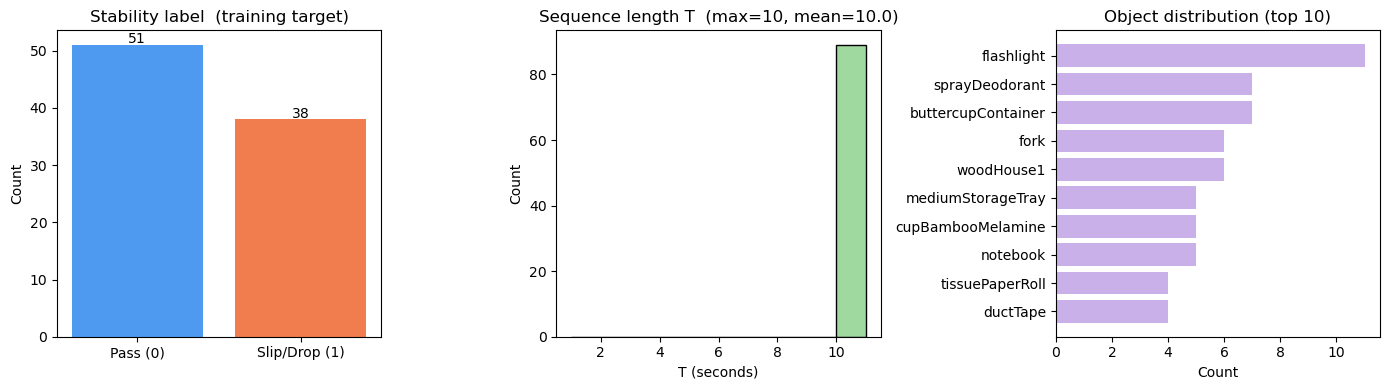


Force levels: {'F5': 46, 'F15': 2, 'F40': 3, 'F80': 38}


In [82]:
# =============================================================================
# SECTION 9 — DATASET LOAD & STATS
# =============================================================================

# --- Load (subsampled for speed) ---
ds = PoseItDataset(root_dir=ROOT_DIR)
if SUBSAMPLE < 1.0:
    k = max(4, int(len(ds.samples) * SUBSAMPLE))
    ds.samples = random.sample(ds.samples, k)
    print(f"Subsampled to {len(ds.samples)} samples")

print(f"\nTotal samples loaded: {len(ds)}")

# --- Label distribution ---
labels_arr      = np.array([s['label'].item()      for s in ds.samples])
pose_labels_arr = np.array([s['pose_label'].item() for s in ds.samples])
n_pass  = (labels_arr == 0).sum()
n_fail  = (labels_arr == 1).sum()
print(f"\nStability label:  {n_pass} pass ({n_pass/len(ds)*100:.1f}%)  |  {n_fail} slip/drop ({n_fail/len(ds)*100:.1f}%)")
n_pp  = (pose_labels_arr == 0).sum()
n_pf  = (pose_labels_arr == 1).sum()
print(f"Pose label:       {n_pp} pass ({n_pp/len(ds)*100:.1f}%)  |  {n_pf} slip/drop ({n_pf/len(ds)*100:.1f}%)")

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Stability label distribution
axes[0].bar(['Pass (0)', 'Slip/Drop (1)'], [n_pass, n_fail], color=['#4e9af1', '#f17c4e'])
axes[0].set_title('Stability label  (training target)')
axes[0].set_ylabel('Count')
for bar, val in zip(axes[0].patches, [n_pass, n_fail]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, str(val), ha='center')

# Sequence length distribution
seq_lens = [s['tactile'].shape[0] for s in ds.samples]
axes[1].hist(seq_lens, bins=range(1, max(seq_lens)+2), edgecolor='k', color='#a0d9a0')
axes[1].set_title(f'Sequence length T  (max={max(seq_lens)}, mean={np.mean(seq_lens):.1f})')
axes[1].set_xlabel('T (seconds)')
axes[1].set_ylabel('Count')

# Object distribution (top 10)
from collections import Counter
obj_counts = Counter(s['object'] for s in ds.samples)
top_objs   = sorted(obj_counts.items(), key=lambda x: -x[1])[:10]
axes[2].barh([x[0] for x in top_objs], [x[1] for x in top_objs], color='#c9b0e8')
axes[2].set_title('Object distribution (top 10)')
axes[2].set_xlabel('Count')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

# Force level breakdown
force_counts = Counter(s['force'] for s in ds.samples)
print(f"\nForce levels: { {f'F{int(f)}': c for f, c in sorted(force_counts.items())} }")

Split (object):  train=81  val=8  test=0
  Train :   81 samples  —  pass=48 (59%)  slip/drop=33 (41%)
  Val   :    8 samples  —  pass=3 (38%)  slip/drop=5 (62%)
  Test  :    0 samples  —  pass=0 (0%)  slip/drop=0 (0%)

[DRSSampler] |S=|=65, |S≠|=16, r=0.2462, σ=1.0, keep_prob(S=)=0.2462, batch_size=64, deferred=True
  S=  indices: 65
  S≠  indices: 16
  r  (natural ratio): 0.2462
  σ  (target ratio):  1.0
  keep_prob(S=):      0.2462
[DRSSampler] DRS activated.


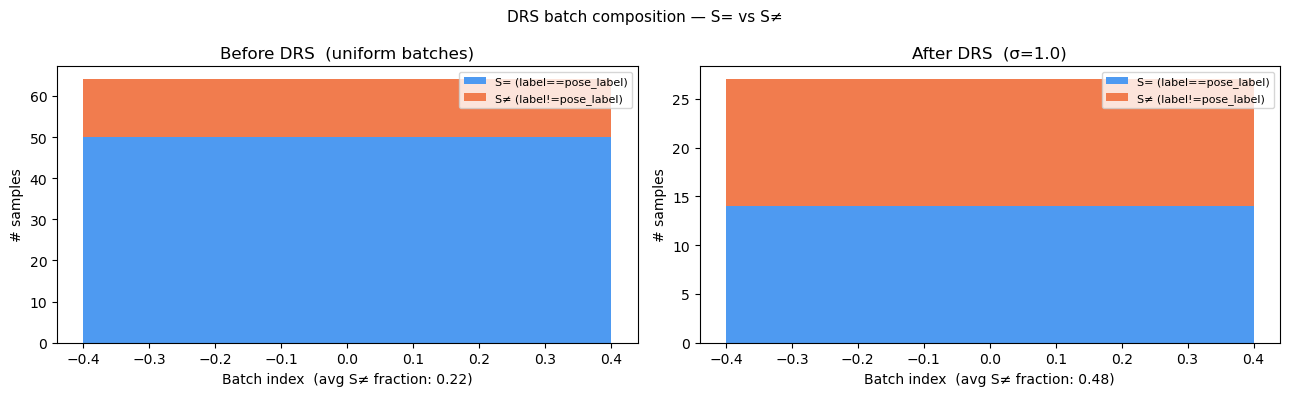

In [83]:
# =============================================================================
# SECTION 10 — SPLITS & DRS SAMPLER
# =============================================================================

# --- Build split ---
if SPLIT == 'object':
    train_set, val_set, test_set = split_by_object(ds, test_objects=TEST_OBJECTS)
elif SPLIT == 'pose':
    train_set, val_set, test_set = split_by_pose(ds, test_pose_indices=TEST_POSES)
else:
    train_set, val_set, test_set = uniform_random_split(ds)

print(f"Split ({SPLIT}):  train={len(train_set)}  val={len(val_set)}  test={len(test_set)}")

def split_labels(dataset, indices):
    lbl = np.array([dataset.samples[i]['label'].item() for i in indices])
    n0, n1 = (lbl==0).sum(), (lbl==1).sum()
    return n0, n1

for name, subset in [('Train', train_set), ('Val', val_set), ('Test', test_set)]:
    n0, n1 = split_labels(ds, subset.indices)
    print(f"  {name:6s}: {len(subset.indices):4d} samples  —  "
          f"pass={n0} ({n0/max(len(subset.indices),1)*100:.0f}%)  "
          f"slip/drop={n1} ({n1/max(len(subset.indices),1)*100:.0f}%)")

# --- DRS Sampler ---
print()
sampler = DRSSampler(
    dataset=ds,
    sigma=SIGMA,
    batch_size=BATCH_SIZE,
    indices=train_set.indices,
)
print(f"  S=  indices: {len(sampler.s_eq)}")
print(f"  S≠  indices: {len(sampler.s_neq)}")
print(f"  r  (natural ratio): {sampler.r:.4f}")
print(f"  σ  (target ratio):  {SIGMA}")
print(f"  keep_prob(S=):      {sampler.keep_prob:.4f}")

# --- Simulate batches before and after DRS activation ---
def simulate_batches(sampler, n=20):
    """Return list of (n_eq, n_neq) per batch."""
    stats = []
    s_neq_set = set(sampler.s_neq.tolist())
    for batch in list(sampler)[:n]:
        n_neq = sum(1 for i in batch if i in s_neq_set)
        n_eq  = len(batch) - n_neq
        stats.append((n_eq, n_neq))
    return stats

pre_stats = simulate_batches(sampler, n=20)
sampler.activate()
post_stats = simulate_batches(sampler, n=20)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))
for ax, stats, title in [
    (axes[0], pre_stats,  "Before DRS  (uniform batches)"),
    (axes[1], post_stats, f"After DRS  (σ={SIGMA})"),
]:
    n_eq_list  = [s[0] for s in stats]
    n_neq_list = [s[1] for s in stats]
    x = range(len(stats))
    ax.bar(x, n_eq_list,  label='S= (label==pose_label)', color='#4e9af1')
    ax.bar(x, n_neq_list, bottom=n_eq_list, label='S≠ (label!=pose_label)', color='#f17c4e')
    ax.set_title(title)
    ax.set_xlabel("Batch index")
    ax.set_ylabel("# samples")
    ax.legend(fontsize=8)
    avg_neq_frac = np.mean([n1/(n0+n1) if (n0+n1)>0 else 0 for n0,n1 in stats])
    ax.set_xlabel(f"Batch index  (avg S≠ fraction: {avg_neq_frac:.2f})")

plt.suptitle("DRS batch composition — S= vs S≠", fontsize=11)
plt.tight_layout()
plt.show()

[DRSSampler] |S=|=65, |S≠|=16, r=0.2462, σ=1.0, keep_prob(S=)=0.2462, batch_size=64, deferred=True
Collated batch shapes:
  tactile       : (64, 10, 1, 3, 224, 224)  (B, T, F1, C, H, W)
  rgb           : (64, 10, 1, 3, 224, 224)
  ft            : (64, 10, 6)  (B, T, FT_DIM=6)
  gripper       : (64, 10, 2)  (B, T, GR_DIM=2)
  gripper_force : (64, 1)  (B, 1)
  label         : (64,)  values=[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1]
  pose_label    : (64,)  values=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]
  lengths       : [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

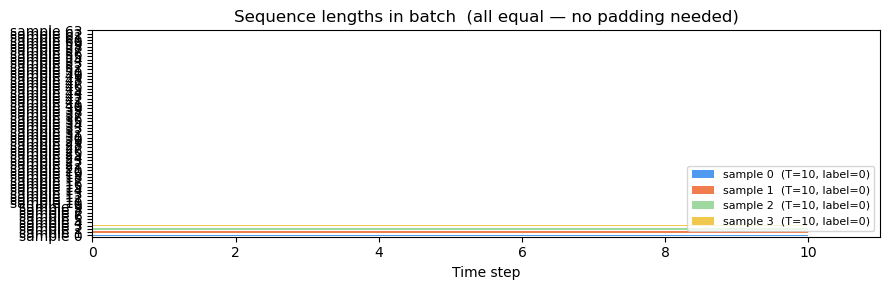

In [84]:
# =============================================================================
# SECTION 11 — DATALOADER BATCH INSPECTION
# =============================================================================

# Re-create sampler (deactivated — we want uniform batches here for clarity)
sampler_inspect = DRSSampler(
    dataset=ds, sigma=SIGMA, batch_size=BATCH_SIZE, indices=train_set.indices
)

train_loader = DataLoader(
    ds,
    batch_sampler=sampler_inspect,
    num_workers=0,
)

batch = next(iter(train_loader))
tac_b, rgb_b, ft_b, grip_b, gf_b, lbl_b, pl_b = batch
lengths_b = [tac_b.shape[1]] * tac_b.shape[0]  # uniform T since L is fixed

print("Collated batch shapes:")
print(f"  tactile       : {tuple(tac_b.shape)}  (B, T, F1, C, H, W)")
print(f"  rgb           : {tuple(rgb_b.shape)}")
print(f"  ft            : {tuple(ft_b.shape)}  (B, T, FT_DIM={FT_DIM})")
print(f"  gripper       : {tuple(grip_b.shape)}  (B, T, GR_DIM={GR_DIM})")
print(f"  gripper_force : {tuple(gf_b.shape)}  (B, 1)")
print(f"  label         : {tuple(lbl_b.shape)}  values={lbl_b.tolist()}")
print(f"  pose_label    : {tuple(pl_b.shape)}  values={pl_b.tolist()}")
print(f"  lengths       : {lengths_b}  (uniform — derived from shape, L={_dl.L})")
print(f"\n  T={tac_b.shape[1]}  (all sequences same length since L is fixed)")

B = tac_b.shape[0]
T = tac_b.shape[1]

# --- Visualise sequence lengths (all equal) ---
fig, ax = plt.subplots(figsize=(9, 3))
colors = ['#4e9af1', '#f17c4e', '#a0d9a0', '#f1c84e']
for i, (L_i, c) in enumerate(zip(lengths_b, colors)):
    ax.barh(i, L_i, height=0.5, color=c,
            label=f'sample {i}  (T={L_i}, label={lbl_b[i].item()})')
ax.set_xlim(0, T + 1)
ax.set_yticks(range(B))
ax.set_yticklabels([f"sample {i}" for i in range(B)])
ax.set_xlabel("Time step")
ax.set_title("Sequence lengths in batch  (all equal — no padding needed)")
ax.legend(fontsize=8, loc='lower right')
plt.tight_layout()
plt.show()

In [85]:
# =============================================================================
# SECTION 12 — MODEL ARCHITECTURE & FORWARD PASS
# =============================================================================

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GraspStabilityLSTM(
    frames_per_sec=F2,
    ft_dim=FT_DIM,
    gripper_dim=GR_DIM,
    hidden_dim=512,
    dropout=0.1,
    modalities=['V', 'T', 'FT', 'G', 'GF'],
).to(device)

# --- Parameter counts ---
def count_params(module):
    total     = sum(p.numel() for p in module.parameters())
    trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
    return total, trainable

components = [
    ('rgb_encoder',     model.rgb_encoder),
    ('tactile_encoder', model.tactile_encoder),
    ('projection',      model.projection),
    ('lstm',            model.lstm),
    ('classifier',      model.classifier),
]
print(f"{'Component':<22} {'Total':>12} {'Trainable':>12}")
print("-" * 48)
grand_total = grand_trainable = 0
for name, mod in components:
    tot, tr = count_params(mod)
    frozen_tag = '' if tr > 0 else '  [FROZEN]'
    print(f"  {name:<20} {tot:>12,} {tr:>12,}{frozen_tag}")
    grand_total     += tot
    grand_trainable += tr
print("-" * 48)
print(f"  {'TOTAL':<20} {grand_total:>12,} {grand_trainable:>12,}")
print(f"\n  Trainable fraction: {grand_trainable/grand_total*100:.2f}%")

# --- Forward pass with shape trace ---
print("\n" + "=" * 60)
print("Forward pass shape trace")
print("=" * 60)

tac_b_dev  = tac_b.to(device)
rgb_b_dev  = rgb_b.to(device)
ft_b_dev   = ft_b.to(device)
grip_b_dev = grip_b.to(device)
gf_b_dev   = gf_b.to(device)

B, T, F1_dim = tac_b_dev.shape[:3]
print(f"\nInput shapes  (B={B}, T={T}, F1={F1_dim}):")
print(f"  tactile       : {tuple(tac_b_dev.shape)}")
print(f"  rgb           : {tuple(rgb_b_dev.shape)}")
print(f"  ft            : {tuple(ft_b_dev.shape)}")
print(f"  gripper       : {tuple(grip_b_dev.shape)}")
print(f"  gripper_force : {tuple(gf_b_dev.shape)}")

print(f"\nPer-second ResNet encoding:")
S = T * F1_dim
print(f"  Reshape tactile: (B*T*F1, 3, 224, 224) = ({B*T*F1_dim}, 3, 224, 224)")
print(f"  ResNet50 → (B*T*F1, 2048) = ({B*T*F1_dim}, 2048)")
print(f"  Reshape back: (B, T, F1*2048) = ({B}, {T}, {F1_dim*2048})")

pre_lstm_dim = F1_dim * 2048 * 2 + FT_DIM + GR_DIM + 1
print(f"\nFusion concat dim: F1*2048*2 + FT_DIM + GR_DIM + 1")
print(f"  = {F1_dim}*2048*2 + {FT_DIM} + {GR_DIM} + 1 = {pre_lstm_dim}")
print(f"  After projection: (B, T, hidden_dim=256) = ({B}, {T}, 256)")

print(f"\nBiLSTM (2-layer, bidirectional):")
print(f"  Input : (B, T, 256) = ({B}, {T}, 256)")
print(f"  Output: (B, T, 512) = ({B}, {T}, 512)  [hidden_dim*2 for bidirectional]")
print(f"  Use last timestep: lstm_out[:, -1, :] → (B, 512)")

print(f"\nClassifier head:")
print(f"  Linear(512→64) → ReLU → Dropout → Linear(64→1)")
print(f"  Output: (B, 1) = ({B}, 1)  [raw logit]")

model.eval()
with torch.no_grad():
    logits = model(tac_b_dev, rgb_b_dev, ft_b_dev, grip_b_dev, gf_b_dev)
print(f"\nActual output — logits shape: {tuple(logits.shape)}")
print(f"  logits:          {logits.squeeze(1).cpu().tolist()}")
print(f"  sigmoid(logits): {logits.squeeze(1).sigmoid().cpu().tolist()}")
print(f"  predictions:     {(logits.squeeze(1) > 0).cpu().tolist()}  (True=slip/drop)")
print(f"  ground truth:    {lbl_b.tolist()}")

Component                     Total    Trainable
------------------------------------------------
  rgb_encoder            23,508,032            0  [FROZEN]
  tactile_encoder        23,508,032            0  [FROZEN]
  projection              2,102,272    2,102,272
  lstm                   10,502,144   10,502,144
  classifier                 65,665       65,665
------------------------------------------------
  TOTAL                  59,686,145   12,670,081

  Trainable fraction: 21.23%

Forward pass shape trace

Input shapes  (B=64, T=10, F1=1):
  tactile       : (64, 10, 1, 3, 224, 224)
  rgb           : (64, 10, 1, 3, 224, 224)
  ft            : (64, 10, 6)
  gripper       : (64, 10, 2)
  gripper_force : (64, 1)

Per-second ResNet encoding:
  Reshape tactile: (B*T*F1, 3, 224, 224) = (640, 3, 224, 224)
  ResNet50 → (B*T*F1, 2048) = (640, 2048)
  Reshape back: (B, T, F1*2048) = (64, 10, 2048)

Fusion concat dim: F1*2048*2 + FT_DIM + GR_DIM + 1
  = 1*2048*2 + 6 + 2 + 1 = 4105
  After pr

Part A: Overfit sanity check  (1 sample, 150 iters)


[WARN] Skipping ductTape_1611177444_F80_pose5: [Errno 2] No such file or directory: '/ocean/projects/cis260031p/shared/dataset/Gelsight/ductTape_1611177444_F80_pose5/gelsight'
Loaded 178 samples (314 skipped)  [L=10, F1=1, F2=1, phase='grasp+pose']
  Single sample label: 0  (pass)
  iter   0: loss=0.7629  logit=0.135  pred=slip
  iter  30: loss=0.5111  logit=-0.405  pred=pass
  iter  60: loss=0.2367  logit=-1.320  pred=pass
  iter  90: loss=0.0836  logit=-2.439  pred=pass
  iter 120: loss=0.0379  logit=-3.253  pred=pass


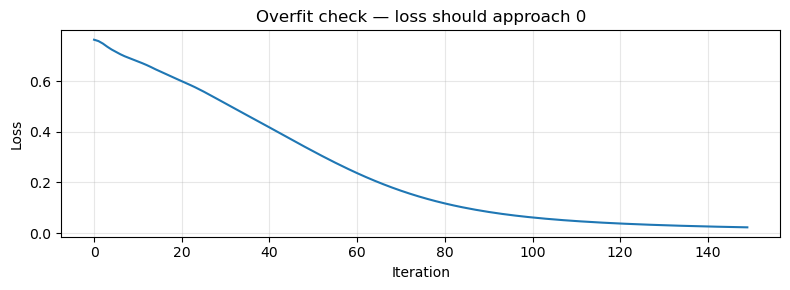


  Final loss: 0.0229  [PASS]


In [86]:
# =============================================================================
# SECTION 13 — MINI TRAINING LOOP & TRAINING BEHAVIOR DIAGNOSIS
# =============================================================================

import torch.nn as nn

# ---- Part A: Overfit sanity check (1 sample, loss must fall to ~0) ----
print("Part A: Overfit sanity check  (1 sample, 150 iters)")
print("=" * 55)

ds_over = PoseItDataset(root_dir=ROOT_DIR)
ds_over.samples = ds_over.samples[:1]
over_loader = DataLoader(ds_over, batch_size=1, shuffle=False, num_workers=0)

model_over = GraspStabilityLSTM(
    frames_per_sec=F2, ft_dim=FT_DIM, gripper_dim=GR_DIM,
    hidden_dim=256, dropout=0.0, modalities=['V','T','FT','G','GF'],
).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model_over.parameters()),
    lr=0.001, momentum=0.9, weight_decay=0.0,
)

overfit_losses = []
overfit_batch  = next(iter(over_loader))
tac_o, rgb_o, ft_o, grip_o, gf_o, lbl_o, _ = [
    x.to(device) if hasattr(x,'to') else x for x in overfit_batch
]
print(f"  Single sample label: {lbl_o.item()}  ({'slip/drop' if lbl_o.item()==1 else 'pass'})")

model_over.train()
for it in range(150):
    optimizer.zero_grad()
    logit = model_over(tac_o, rgb_o, ft_o, grip_o, gf_o).squeeze(1)
    loss  = criterion(logit, lbl_o.float())
    loss.backward()
    optimizer.step()
    overfit_losses.append(loss.item())
    if it % 30 == 0:
        print(f"  iter {it:3d}: loss={loss.item():.4f}  "
              f"logit={logit.item():.3f}  pred={'slip' if logit.item()>0 else 'pass'}")

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(overfit_losses)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("Overfit check — loss should approach 0")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

final_loss = overfit_losses[-1]
status = "PASS" if final_loss < 0.1 else "CONCERN (may need more iters or lower LR)"
print(f"\n  Final loss: {final_loss:.4f}  [{status}]")

Part B: Training behavior diagnosis
[DRSSampler] |S=|=65, |S≠|=16, r=0.2462, σ=1.0, keep_prob(S=)=0.2462, batch_size=64, deferred=True
  1 epoch = 1 batches  (81 train samples ÷ BATCH_SIZE=64)


  iter    0: train_loss=0.6859  val_acc=37.5%  prec=0.000  rec=0.000  f1=0.000
  iter  100: train_loss=0.6749  val_acc=37.5%  prec=0.000  rec=0.000  f1=0.000
[DRSSampler] DRS activated.

  [iter 150] DRS activated  ← batch composition changes here
  iter  200: train_loss=0.6790  val_acc=62.5%  prec=0.625  rec=1.000  f1=0.769


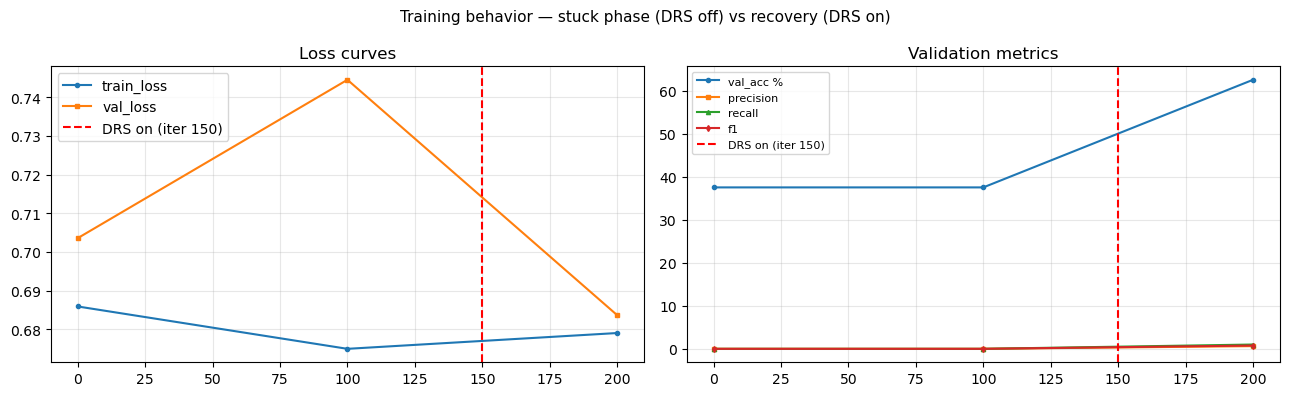

In [87]:
# ---- Part B: Simulate the stuck-at-50% training behavior & explain it ----
# 1 iteration  = 1 batch (forward + backward + optimizer step)
# 1 epoch      = _n_batches iterations = n_train // BATCH_SIZE
# DEMO_ITERS   = total iterations across all epochs
print("Part B: Training behavior diagnosis")
print("=" * 55)

@torch.no_grad()
def quick_eval(model, loader, criterion, device):
    model.eval()
    tp, fp, fn, n, total_loss = 0, 0, 0, 0, 0.0
    for batch in loader:
        tac, rgb, ft, grip, gf, lbl, _ = [
            x.to(device) if hasattr(x,'to') else x for x in batch
        ]
        logits = model(tac, rgb, ft, grip, gf).squeeze(1)
        total_loss += criterion(logits, lbl.float()).item() * len(lbl)
        preds  = logits > 0
        actual = lbl.bool()
        tp += (preds &  actual).sum().item()
        fp += (preds & ~actual).sum().item()
        fn += (~preds & actual).sum().item()
        n  += len(lbl)
    if n == 0: return 0,0,0,0,0
    acc  = (tp + (n - tp - fp - fn)) / n
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0.0
    return total_loss/n, acc, prec, rec, f1

# Build small multi-sample loaders for the demo
val_loader_demo = DataLoader(
    val_set, batch_size=max(1, len(val_set)), shuffle=False,
    num_workers=0,
)
sampler_demo = DRSSampler(
    dataset=ds, sigma=SIGMA, batch_size=BATCH_SIZE, indices=train_set.indices
)
train_loader_demo = DataLoader(
    ds, batch_sampler=sampler_demo, num_workers=0
)
print(f"  1 epoch = {len(sampler_demo)} batches  "
      f"({len(train_set)} train samples ÷ BATCH_SIZE={BATCH_SIZE})")

model_diag = GraspStabilityLSTM(
    frames_per_sec=F2, ft_dim=FT_DIM, gripper_dim=GR_DIM,
    hidden_dim=256, dropout=0.1, modalities=['V','T','FT','G','GF'],
).to(device)
opt_diag = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model_diag.parameters()),
    lr=0.001, momentum=0.9, weight_decay=0.01,
)
crit = nn.BCEWithLogitsLoss()

DEMO_ITERS = 300   # total iterations
DRS_AT     = 150   # activate DRS at iteration 1500 (halfway — matches train.py ratio)

history = {'iter':[], 'train_loss':[], 'val_loss':[], 'val_acc':[], 'prec':[], 'rec':[], 'f1':[]}

model_diag.train()
it = 0
# Outer while restarts epochs; inner for runs one epoch (len(sampler_demo) batches)
while it < DEMO_ITERS:
    for batch in train_loader_demo:
        if it >= DEMO_ITERS:
            break
        if it == DRS_AT:
            sampler_demo.activate()
            print(f"\n  [iter {it}] DRS activated  ← batch composition changes here")

        tac, rgb, ft, grip, gf, lbl, _ = [
            x.to(device) if hasattr(x,'to') else x for x in batch
        ]
        opt_diag.zero_grad()
        logit = model_diag(tac, rgb, ft, grip, gf).squeeze(1)
        loss  = crit(logit, lbl.float())
        loss.backward()
        opt_diag.step()

        if it % 100 == 0:
            vl, va, vp, vr, vf = quick_eval(model_diag, val_loader_demo, crit, device)
            history['iter'].append(it);       history['train_loss'].append(loss.item())
            history['val_loss'].append(vl);   history['val_acc'].append(va)
            history['prec'].append(vp);       history['rec'].append(vr);  history['f1'].append(vf)
            print(f"  iter {it:4d}: train_loss={loss.item():.4f}  val_acc={va*100:.1f}%  "
                  f"prec={vp:.3f}  rec={vr:.3f}  f1={vf:.3f}")
            model_diag.train()
        it += 1

# Plot
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
iters = history['iter']
axes[0].plot(iters, history['train_loss'], label='train_loss', marker='o', markersize=3)
axes[0].plot(iters, history['val_loss'],   label='val_loss',   marker='s', markersize=3)
axes[0].axvline(DRS_AT, color='red', linestyle='--', label=f'DRS on (iter {DRS_AT})')
axes[0].set_title("Loss curves");  axes[0].legend();  axes[0].grid(True, alpha=0.3)

axes[1].plot(iters, [v*100 for v in history['val_acc']], label='val_acc %', marker='o', markersize=3)
axes[1].plot(iters, history['prec'], label='precision', marker='s', markersize=3)
axes[1].plot(iters, history['rec'],  label='recall',    marker='^', markersize=3)
axes[1].plot(iters, history['f1'],   label='f1',        marker='d', markersize=3)
axes[1].axvline(DRS_AT, color='red', linestyle='--', label=f'DRS on (iter {DRS_AT})')
axes[1].set_title("Validation metrics");  axes[1].legend(fontsize=8);  axes[1].grid(True, alpha=0.3)

plt.suptitle("Training behavior — stuck phase (DRS off) vs recovery (DRS on)", fontsize=11)
plt.tight_layout()
plt.show()

In [88]:
# ---- Part C: Training behavior diagnosis printout ----
print("=" * 65)
print("DIAGNOSIS: What you observed in your training run")
print("=" * 65)

# Compute class imbalance from loaded dataset
n_pass_train = sum(1 for i in train_set.indices if ds.samples[i]['label'].item() == 0)
n_fail_train = sum(1 for i in train_set.indices if ds.samples[i]['label'].item() == 1)
n_train = len(train_set.indices)

print(f"""
1. val_acc=50%, prec=0, rec=0, f1=0  (iters 0–299)
   ─────────────────────────────────────────────────
   The model collapsed to predicting ALL-NEGATIVE (no slip/drop).
   
   Why: Training data is imbalanced.
     Your run: |train| = {n_train} samples
               pass (0):      {n_pass_train} ({n_pass_train/n_train*100:.0f}%)
               slip/drop (1): {n_fail_train} ({n_fail_train/n_train*100:.0f}%)
   
   With DRS off, a random batch of 32 likely has ~{int(32*n_fail_train/n_train)} slip/drop
   samples and ~{int(32*n_pass_train/n_train)} pass. The model finds the trivial local
   minimum: predict 0 always → achieves ~{n_pass_train/n_train*100:.0f}% train accuracy.
   
   Why val_acc=50% (not ~{n_pass_train/n_train*100:.0f}%): The val set (from object split)
   happens to be ~50% balanced.

2. val_loss monotonically increasing
   ─────────────────────────────────
   The model isn't confused; it's growing MORE CONFIDENT in
   wrong predictions. As logits drift negative, BCE loss on
   each positive val sample = -log(sigmoid(logit)) keeps rising.

3. train_loss fluctuating
   ──────────────────────
   Only the projection+LSTM+classifier are trainable (frozen ResNet).
   Batch-to-batch variance in the # of slip/drop samples causes
   noisy gradient estimates → oscillating loss. This is expected
   with SGD + small batches on imbalanced data.

4. Expected fix at iter 300
   ────────────────────────
   DRS activates + LR anneals ×0.1. DRS forces σ={SIGMA} ratio of
   S≠/S= samples per batch, so the model sees many more slip/drop
   examples. The lower LR helps escape the trivial minimum.
   
   Watch for: recall and f1 becoming non-zero after iter 300.
   If still stuck at iter 400+, consider:
     a) Unfreeze last ResNet layer  (freeze_resnet=False or partial)
     b) Switch to Adam  (more robust to noisy gradients)
     c) Lower weight_decay  (0.01 may be too aggressive for the small head)
""")

DIAGNOSIS: What you observed in your training run

1. val_acc=50%, prec=0, rec=0, f1=0  (iters 0–299)
   ─────────────────────────────────────────────────
   The model collapsed to predicting ALL-NEGATIVE (no slip/drop).

   Why: Training data is imbalanced.
     Your run: |train| = 81 samples
               pass (0):      48 (59%)
               slip/drop (1): 33 (41%)

   With DRS off, a random batch of 32 likely has ~13 slip/drop
   samples and ~18 pass. The model finds the trivial local
   minimum: predict 0 always → achieves ~59% train accuracy.

   Why val_acc=50% (not ~59%): The val set (from object split)
   happens to be ~50% balanced.

2. val_loss monotonically increasing
   ─────────────────────────────────
   The model isn't confused; it's growing MORE CONFIDENT in
   wrong predictions. As logits drift negative, BCE loss on
   each positive val sample = -log(sigmoid(logit)) keeps rising.

3. train_loss fluctuating
   ──────────────────────
   Only the projection+LSTM+classi